In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [6]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Displaying the created weights fo
# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals","Bird","Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

mean_newvalue_hist= {}
mean_newvalue_fut = {}
mean_sumbin_hist = {}
mean_sumbin_fut = {}
    
mean_over_sdms_gcms_hist = {}
mean_over_sdms_gcms_fut = {}
mean_over_sdms_gcms_sumbin_hist = {}
mean_over_sdms_gcms_sumbin_fut = {}

mean_over_all_sdms_gcms_hist = {}
mean_over_all_sdms_gcms_fut = {}
mean_over_all_sdms_gcms_sumbin_hist = {}
mean_over_all_sdms_gcms_sumbin_fut = {}

for scenario in scenarios:
    mean_over_sdms_gcms_hist[scenario] = {}
    mean_over_sdms_gcms_fut[scenario] = {}
    mean_over_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_over_all_sdms_gcms_hist[scenario] = {}
    mean_over_all_sdms_gcms_fut[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = {}
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = {}
    
    mean_newvalue_hist[scenario] = {}
    mean_newvalue_fut[scenario] = {}
    mean_sumbin_hist[scenario] = {}
    mean_sumbin_fut[scenario] = {}
    
    dataarrays_sdms_newvalue_hist = []
    dataarrays_sdms_newvalue_fut = []
    dataarrays_sdms_sumbin_hist = []
    dataarrays_sdms_sumbin_fut = []
    


    for sdm in sdms:
        mean_newvalue_hist[scenario][sdm] = {}
        mean_newvalue_fut[scenario][sdm] = {}
        mean_sumbin_hist[scenario][sdm] = {}
        mean_sumbin_fut[scenario][sdm] = {}
        
        dataarrays_newvalue_hist = []
        dataarrays_newvalue_fut = []
        dataarrays_sumbin_hist = []
        dataarrays_sumbin_fut = []

        for gcm in gcms:
            mean_newvalue_hist[scenario][sdm][gcm] = {}
            mean_newvalue_fut[scenario][sdm][gcm] = {}
            mean_sumbin_hist[scenario][sdm][gcm] = {}
            mean_sumbin_fut[scenario][sdm][gcm] = {}
            
            sum_newvalue_hist = None
            sum_newvalue_future = None
            sum_sumbin_hist = None
            sum_sumbin_future = None

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_dispersal4.pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_dispersal4.pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}']_dispersal4.pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_taxa = pickle.load(f)

     # Sum across taxa
                if sum_newvalue_hist is None:
                    sum_newvalue_hist = newvalue_hist_taxa
                    sum_newvalue_future = newvalue_future_taxa
                    sum_sumbin_hist = sum_bin_hist_taxa
                    sum_sumbin_future = sum_bin_future_taxa
                else:
                    sum_newvalue_hist += newvalue_hist_taxa
                    sum_newvalue_future += newvalue_future_taxa
                    sum_sumbin_hist += sum_bin_hist_taxa
                    sum_sumbin_future += sum_bin_future_taxa
                    
                weights_newvalue = np.cos(np.deg2rad(newvalue_hist_taxa.lat))
                weights_newvalue.name = "weights"

                    
                    
            # Assign the summed values to your dictionary
            mean_newvalue_hist[scenario][sdm][gcm] = sum_newvalue_hist
            mean_newvalue_fut[scenario][sdm][gcm] = sum_newvalue_future
            mean_sumbin_hist[scenario][sdm][gcm] = sum_sumbin_hist
            mean_sumbin_fut[scenario][sdm][gcm] = sum_sumbin_future

            dataarrays_newvalue_hist.append(mean_newvalue_hist[scenario][sdm][gcm])
            dataarrays_newvalue_fut.append(mean_newvalue_fut[scenario][sdm][gcm])
            dataarrays_sumbin_hist.append(mean_sumbin_hist[scenario][sdm][gcm])
            dataarrays_sumbin_fut.append(mean_sumbin_fut[scenario][sdm][gcm])

        # Concatenate and calculate the mean over the new dimension
        mean_over_sdms_gcms_hist[scenario][sdm] = xr.concat(dataarrays_newvalue_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_fut[scenario][sdm] = xr.concat(dataarrays_newvalue_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_hist[scenario][sdm] = xr.concat(dataarrays_sumbin_hist, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')
        mean_over_sdms_gcms_sumbin_fut[scenario][sdm] = xr.concat(dataarrays_sumbin_fut, dim='gcm').weighted(weights_newvalue).mean(dim='gcm')

               # Append the mean DataArrays across GCMs to the SDM lists
        dataarrays_sdms_newvalue_hist.append(mean_over_sdms_gcms_hist[scenario][sdm])
        dataarrays_sdms_newvalue_fut.append(mean_over_sdms_gcms_fut[scenario][sdm])
        dataarrays_sdms_sumbin_hist.append(mean_over_sdms_gcms_sumbin_hist[scenario][sdm])
        dataarrays_sdms_sumbin_fut.append(mean_over_sdms_gcms_sumbin_fut[scenario][sdm])

    # Concatenate and calculate the mean over SDMs
    mean_over_all_sdms_gcms_hist[scenario] = xr.concat(dataarrays_sdms_newvalue_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_fut[scenario] = xr.concat(dataarrays_sdms_newvalue_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_hist[scenario] = xr.concat(dataarrays_sdms_sumbin_hist, dim='sdm').weighted(weights_newvalue).mean(dim='sdm')
    mean_over_all_sdms_gcms_sumbin_fut[scenario] = xr.concat(dataarrays_sdms_sumbin_fut, dim='sdm').weighted(weights_newvalue).mean(dim='sdm') 
    

In [3]:
#get the IPBES sub regions
# Read the shapefile

shp_dir = "/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/IPBES_Regions_Subregions2.shp"
shp = gpd.read_file(shp_dir)

# Define the region mapping
region_mapping = {
    'Carribean': 'Caribbean & Mesoamerica',
    'Central Africa': 'West, Central, East & South Africa',
    'Central and Western Europe': 'Central and Western Europe',
    'Central Asia': 'Central, North-East & South Asia',
    'East Africa and adjacent islands': 'West, Central, East & South Africa',
    'Eastern Europe': 'Eastern Europe',
    'Mesoamerica': 'Caribbean & Mesoamerica',
    'North Africa': 'North Africa & Western Asia',
    'North America': 'North America',
    'Nort-East Asia': 'Central, North-East & South Asia',
    'Oceania': 'Oceania',
    'South America': 'South America',
    'South Asia': 'Central, North-East & South Asia',
    'South-East Asia': 'South-East Asia',
    'Southern Africa': 'West, Central, East & South Africa',
    'West Africa': 'West, Central, East & South Africa',
    'Western Asia': 'North Africa & Western Asia'
}

# Create the new_region column in the shapefile
shp['new_region'] = shp['Sub_Region'].map(region_mapping)

#

In [4]:
import matplotlib as mpl
def set_plot_param():

    """Set my own customized plotting parameters"""

    import matplotlib as mpl

    mpl.rc('axes',edgecolor='grey')

    mpl.rc('axes',labelcolor='black')

    mpl.rc('xtick',color='black')

    mpl.rc('xtick',labelsize=12)

    mpl.rc('ytick',color='black')

    mpl.rc('ytick',labelsize=12)

    mpl.rc('axes',titlesize=18)

    mpl.rc('axes',labelsize=12)

    mpl.rc('legend',fontsize='large')

    mpl.rc('text',color='black')
    

    

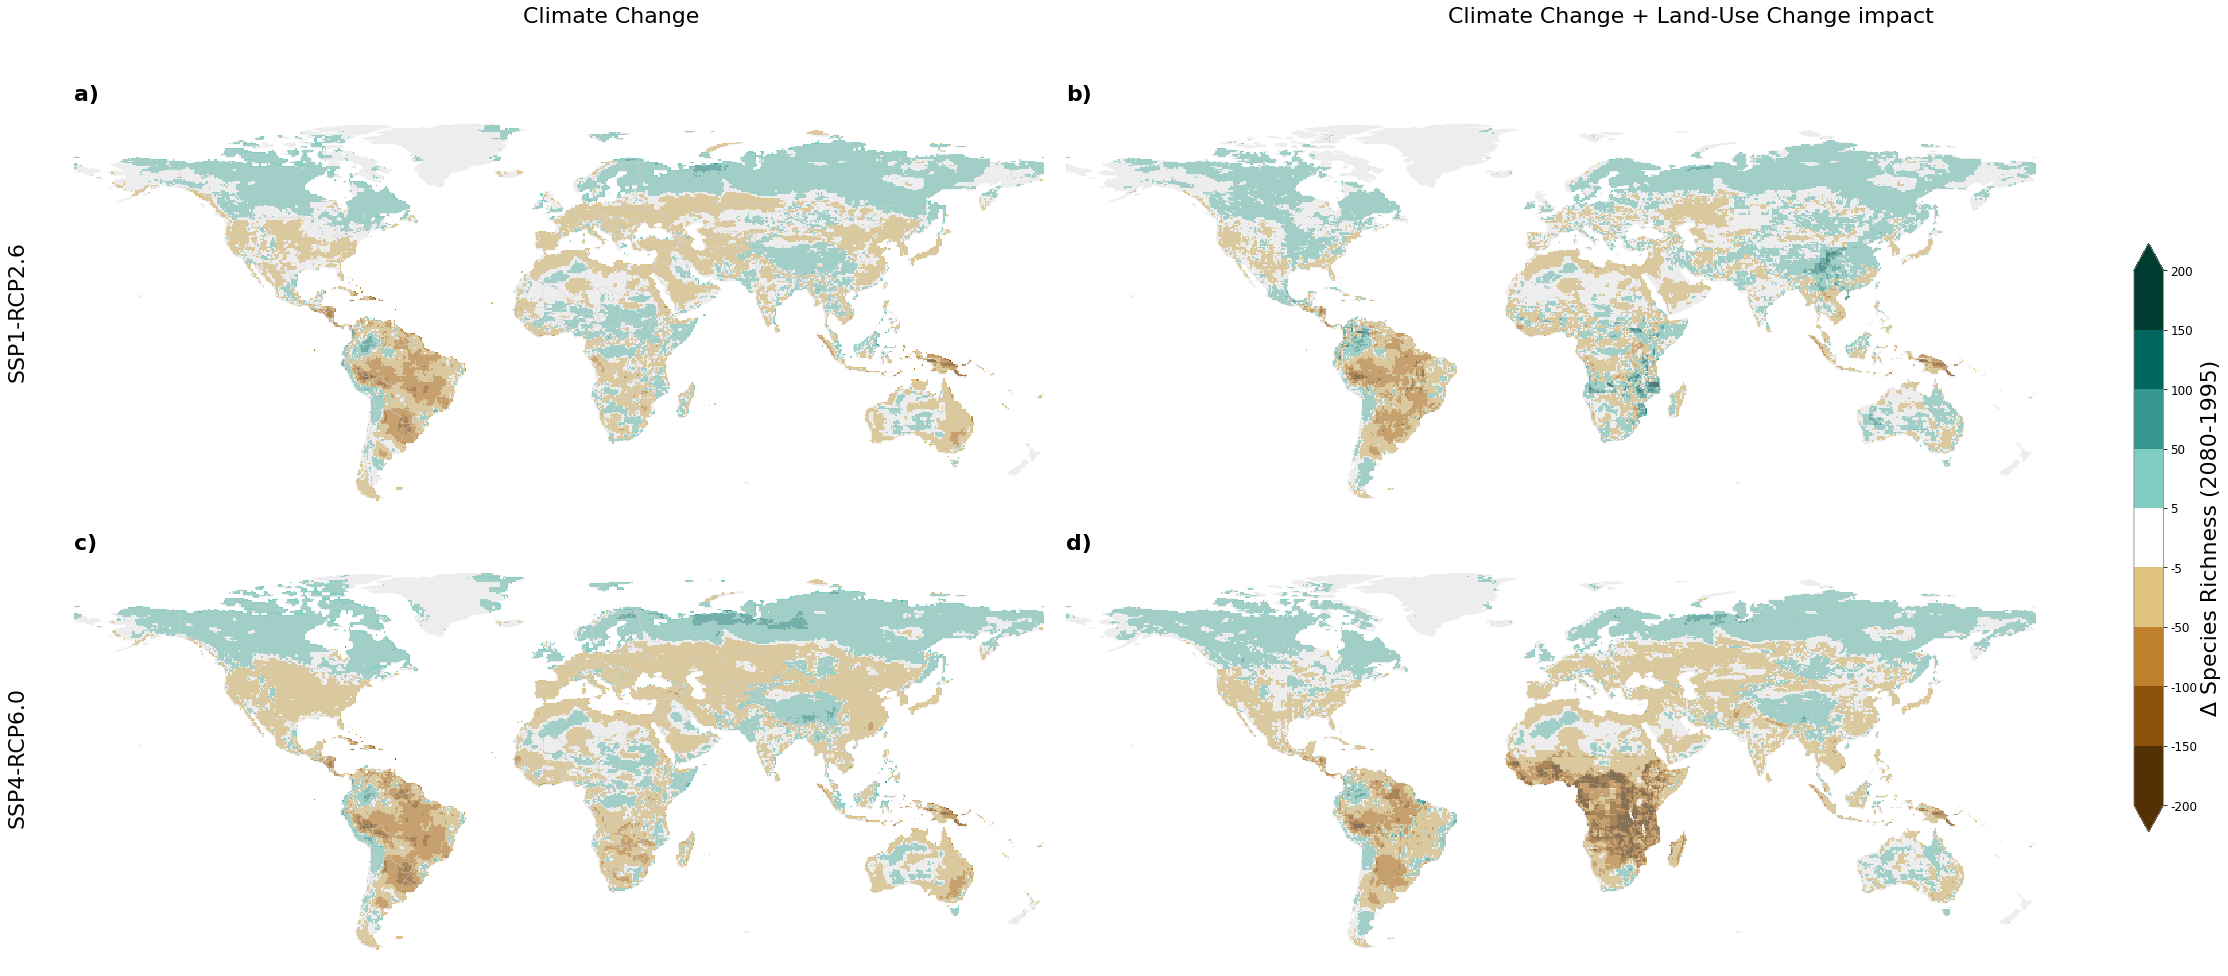

In [9]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

set_plot_param()
scenarios = ["rcp26","rcp60"]
historical_time= 1146
future_time=65

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

scenario_indices={"rcp26": 'SSP1-RCP2.6', "rcp60": 'SSP4-RCP6.0'}
rcp_indices=scenario_indices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
subplot_labels = ['a)', 'b)','c)','d)']
for scenario in scenarios:
    diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
    diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]
    


# Your existing code ...
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]
    labels = [subplot_labels[plot_idx], subplot_labels[plot_idx + 1]]
    
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values
    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffff', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'] RdYlGn but white in the middle 

    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#ffffff', '#a6d96a', '#66bd63', '#1a9850', '#006837'] #RdYlGn but white in the middle and only 8 + white
    
    
    #custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'] #brown to blue
    custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#ffffff', '#80cdc1', '#35978f', '#01665e', '#003c30' ]
    #custom_colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#ffffff', '#c7eae5', '#80cdc1', '#35978f', '#01665e'] # brown to turqois
    cmap = ListedColormap(custom_colors)

    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.4)
   # ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center',fontsize=18 )

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='lightgrey',linewidth=0.5)
    ax1.set_title(labels[0],loc='left',weight='bold', fontsize=22)
    
    #ax1.set_title(f" {year_indices[future_time]} - 1995",loc='center',fontsize=18, x=0.2)
    
    


    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

  
    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.4)

    #ax2.set_title(f" {year_indices[future_time]} - 1995",loc='center',fontsize=18, x=0.2)
    
    
    ax2.set_title(f"{scenario_indices[scenario]}",loc='left',fontsize=22)

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    ax2.set_title(labels[1],loc='left', weight='bold',fontsize=22)



    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2
    

#cbar = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05,extend='both')
cbar.set_label('Δ Species Richness (2080-1995)', fontsize=22)
ticks = np.array([-200, -150, -100, -50, -5,5, 50, 100, 150, 200])
tick_labels = ['-200', '-150', '-100', '-50', '-5', '5','50', '100', '150', '200']

# Setzen Sie die Ticks und Tick-Labels für die Farbleiste
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

fig.text(0.75, 0.85, 'Climate Change + Land-Use Change impact', ha='center', fontsize=22)


# After your plotting loop
fig.text(-0.025, 0.65, f"{scenario_indices['rcp26']}", va='center', ha='center', rotation='vertical', fontsize=22)
fig.text(-0.025, 0.34, f"{scenario_indices['rcp60']}", va='center', ha='center', rotation='vertical', fontsize=22)


# "Climate Change" über den linken oberen Subplot
fig.text(0.25, 0.85, 'Climate Change', ha='center', fontsize=22)

#fig.text(0.5, 0.9, 'Amphibians', ha='center', fontsize=18)

# Show or save the plot

plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_2.png")
plt.show()

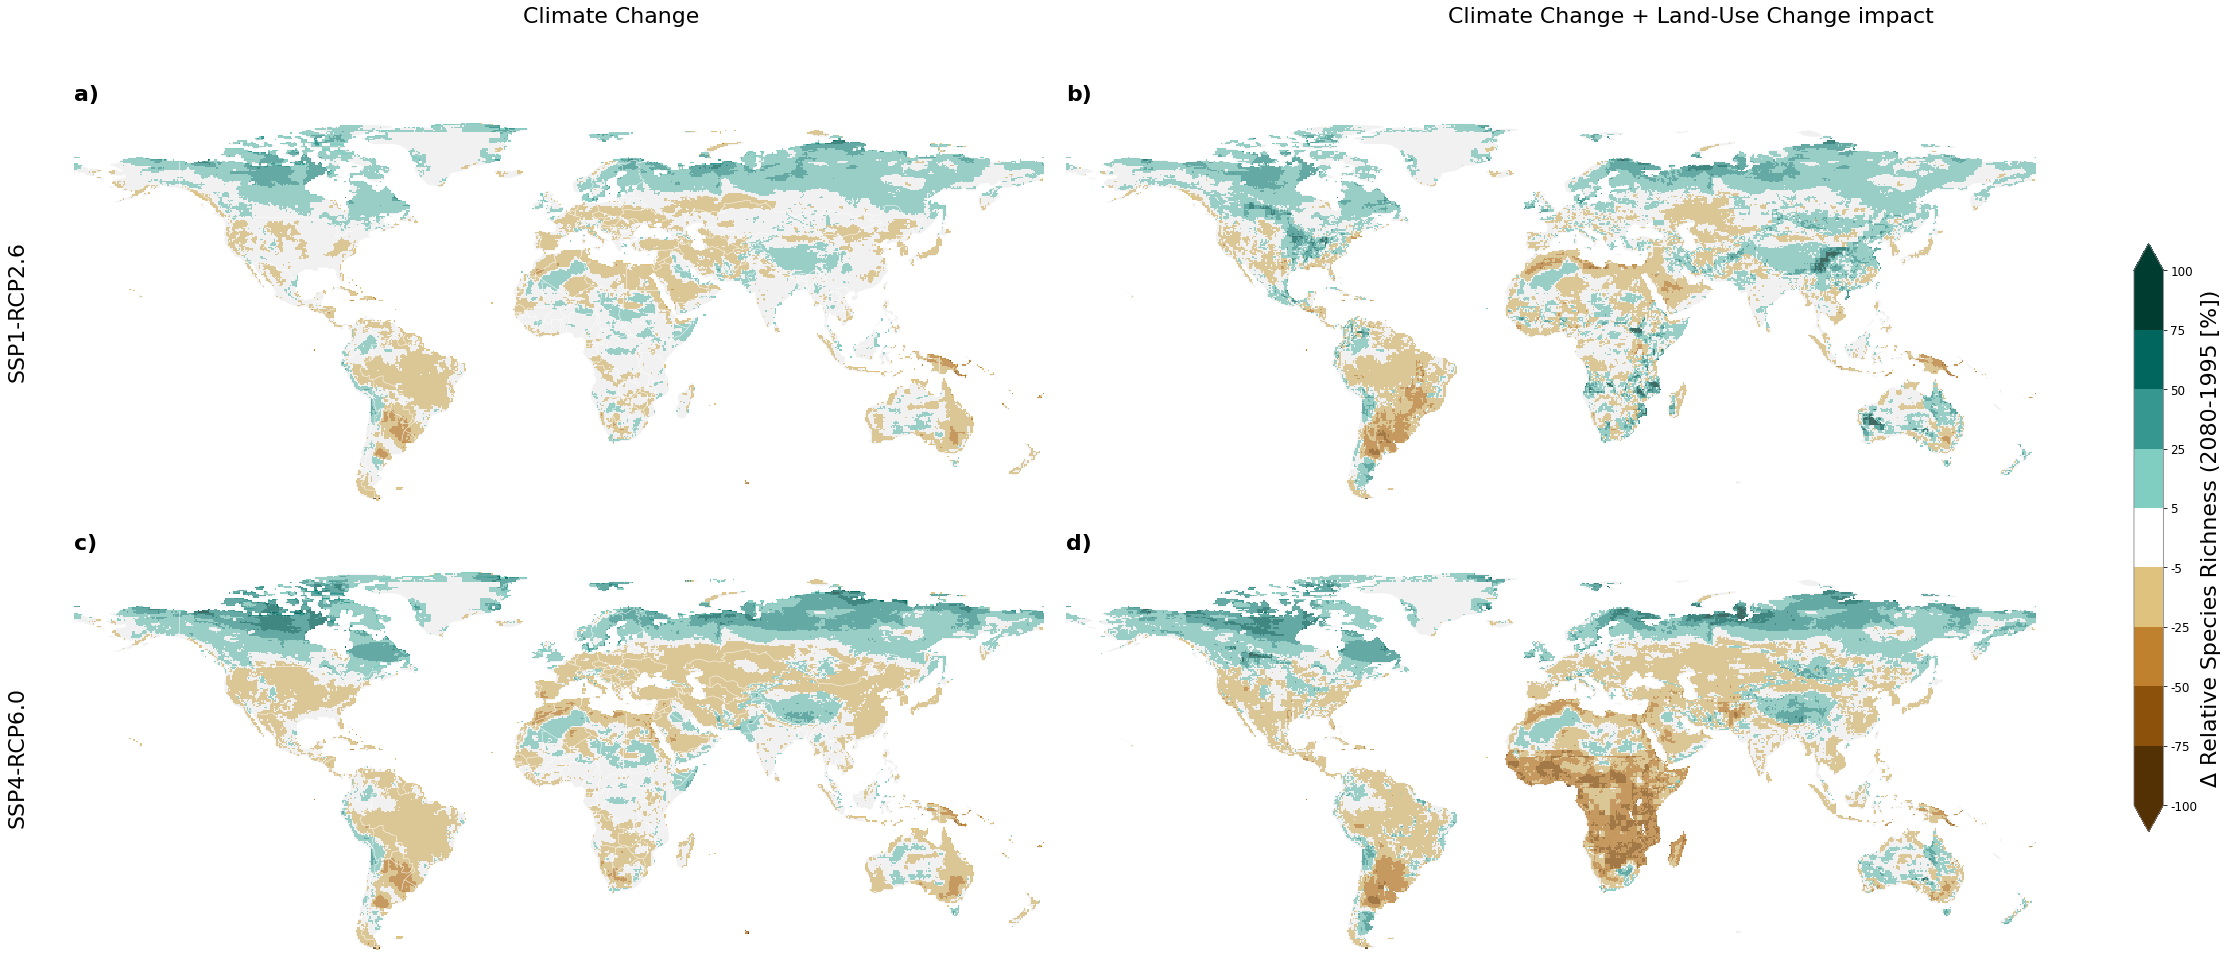

In [37]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Example setup for the plot parameters, scenarios, year indices
# Assuming mean_over_all_sdms_gcms_fut and mean_over_all_sdms_gcms_hist are defined

# Custom colormap for relative changes
custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#ffffff', 
                 '#80cdc1', '#35978f', '#01665e', '#003c30']
cmap = ListedColormap(custom_colors)

# Adjust boundaries for relative changes, e.g., from -100% to 100%
boundaries = np.linspace(-100, 100, len(custom_colors) - 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Initialize figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")

# Load country data for background
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
subplot_labels = ['a)', 'b)', 'c)', 'd)']

for scenario in scenarios:
    # Calculate relative difference avoiding division by zero
    
    diff_newvalue = xr.where(mean_over_all_sdms_gcms_hist[scenario] != 0, (mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]) / mean_over_all_sdms_gcms_hist[scenario] * 100, 0)
    #diff_newvalue =  (mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]) / mean_over_all_sdms_gcms_hist[scenario] * 100

    diff_sumbin=  xr.where(mean_over_all_sdms_gcms_sumbin_hist[scenario] != 0, (mean_over_all_sdms_gcms_sumbin_fut[scenario]  - mean_over_all_sdms_gcms_sumbin_hist[scenario]) / mean_over_all_sdms_gcms_sumbin_hist[scenario] * 100, 0)
    #diff_sumbin=   (mean_over_all_sdms_gcms_sumbin_fut[scenario]  - mean_over_all_sdms_gcms_sumbin_hist[scenario]) / mean_over_all_sdms_gcms_sumbin_hist[scenario] * 100
    

    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]
    labels = [subplot_labels[plot_idx], subplot_labels[plot_idx + 1]]
    
    # Define the colormap and the range of values for the colorbar

    #vmin_b = diff_sum_bin.min().values
    #vmax_b = diff_sum_bin.max().values
    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffff', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837'] RdYlGn but white in the middle 

    #custom_colors = ['#a50026', '#d73027', '#f46d43', '#fdae61', '#ffffff', '#a6d96a', '#66bd63', '#1a9850', '#006837'] #RdYlGn but white in the middle and only 8 + white
    
    
    #custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'] #brown to blue
    custom_colors = ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#ffffff', '#80cdc1', '#35978f', '#01665e', '#003c30' ]
    #custom_colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#ffffff', '#c7eae5', '#80cdc1', '#35978f', '#01665e'] # brown to turqois
    cmap = ListedColormap(custom_colors)

    boundaries =[-100, -75, -50, -25,-5, 5, 25, 50, 75, 100] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="lightgrey", zorder=1, alpha=0.3)
   # ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center',fontsize=18 )

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
    ax1.set_title(labels[0],loc='left',weight='bold', fontsize=22)
    
    #ax1.set_title(f" {year_indices[future_time]} - 1995",loc='center',fontsize=18, x=0.2)
    
    


    ticks_b = np.array( [-100, -75, -50, -25, -5,5, 25, 50, 75, 100])
    tick_labels = [str(int(tick)) for tick in ticks_b]

  
    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgrey", zorder=1, alpha=0.3)

    #ax2.set_title(f" {year_indices[future_time]} - 1995",loc='center',fontsize=18, x=0.2)
    
    
    ax2.set_title(f"{scenario_indices[scenario]}",loc='left',fontsize=22)

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    ax2.set_title(labels[1],loc='left', weight='bold',fontsize=22)



    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2
#cbar = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05,extend='both')
cbar.set_label('Δ Relative Species Richness (2080-1995 [%])', fontsize=22)
ticks = np.array([-100, -75, -50, -25, -5,5, 25, 50, 75, 100])
tick_labels = ['-100', '-75', '-50', '-25', '-5','5' ,'25', '50', '75', '100']

# Setzen Sie die Ticks und Tick-Labels für die Farbleiste
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

fig.text(0.75, 0.85, 'Climate Change + Land-Use Change impact', ha='center', fontsize=22)


# After your plotting loop
fig.text(-0.025, 0.65, f"{scenario_indices['rcp26']}", va='center', ha='center', rotation='vertical', fontsize=22)
fig.text(-0.025, 0.34, f"{scenario_indices['rcp60']}", va='center', ha='center', rotation='vertical', fontsize=22)


# "Climate Change" über den linken oberen Subplot
fig.text(0.25, 0.85, 'Climate Change', ha='center', fontsize=22)

#fig.text(0.5, 0.9, 'Amphibians', ha='center', fontsize=18)

# Show or save the plot
plt.savefig("/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Figure_S2.png")
plt.show()

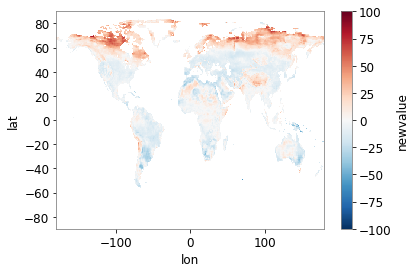

In [26]:
diff_newvalue.plot()

In [8]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) /  sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    result_df.to_csv('/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Fig_2.csv', index=False)
    print(result_df)


diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.000000  0.000000
Central, North-East & South Asia   -0.995513 -2.850700
West, Central, East & South Africa -0.772359 -3.052900
Central and Western Europe         -0.994369 -2.812708
North Africa & Western Asia        -2.379432 -4.460527
South America                      -6.740422 -8.578988
Eastern Europe                      4.131802  5.284226
Oceania                            -4.012639 -5.747342
Caribbean & Mesoamerica            -3.965562 -6.114813
South-East Asia                    -1.853870 -3.118003
North America                       2.580952  2.923255

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26      rcp60
NaN                                 0.000000   0.000000
Central, North-East & South Asia    0.260116  -5.535078
West, Central, East & South Africa  1.030009 -34.495

In [9]:
#absolute differences
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) 
        rel_diff_sumbin = (sumbin_future - sumbin_hist) 

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    result_df.to_csv('/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Fig_2.csv', index=False)
    print(result_df)


diff_newvalue Relative Difference in Mean Species Richness:
                                            rcp26          rcp60
NaN                                      0.000000       0.000000
Central, North-East & South Asia    -14443.925737  -41360.870118
West, Central, East & South Africa  -19639.982992  -77630.845520
Central and Western Europe           -9894.501242  -27987.957687
North Africa & Western Asia         -23516.793198  -44085.015664
South America                      -212695.501229 -270711.856779
Eastern Europe                      171184.824861  218930.932468
Oceania                            -293412.620963 -420257.733791
Caribbean & Mesoamerica             -13244.998423  -20423.509163
South-East Asia                     -14404.999027  -24227.608436
North America                       144754.778216  163953.144965

diff_sumbin Relative Difference in Mean Species Richness:
                                            rcp26          rcp60
NaN                                

In [31]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) /  sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)


diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                -1.145486 -1.973436
Central, North-East & South Asia   -1.145486 -1.973436
West, Central, East & South Africa -1.145486 -1.973436
Central and Western Europe         -1.145486 -1.973436
North Africa & Western Asia        -1.145486 -1.973436
South America                      -1.145486 -1.973436
Eastern Europe                     -1.145486 -1.973436
Oceania                            -1.145486 -1.973436
Caribbean & Mesoamerica            -1.145486 -1.973436
South-East Asia                    -1.145486 -1.973436
North America                      -1.145486 -1.973436

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.351093 -7.545094
Central, North-East & South Asia    0.351093 -7.545094
West, Central, East & South Africa  0.351093 -7.545094


In [41]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26", "rcp60"]

# Initialize lists to store global values
global_diff_newvalue = []
global_diff_sumbin = []

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) / sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin
# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)
result_df.to_csv('/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Fig_2.csv', index=False)



diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.000000  0.000000
Central, North-East & South Asia   -0.995513 -2.850700
West, Central, East & South Africa -0.772359 -3.052900
Central and Western Europe         -0.994369 -2.812708
North Africa & Western Asia        -2.379432 -4.460527
South America                      -6.740422 -8.578988
Eastern Europe                      4.131802  5.284226
Oceania                            -4.012639 -5.747342
Caribbean & Mesoamerica            -3.965562 -6.114813
South-East Asia                    -1.853870 -3.118003
North America                       2.580952  2.923255

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26      rcp60
NaN                                 0.000000   0.000000
Central, North-East & South Asia    0.260116  -5.535078
West, Central, East & South Africa  1.030009 -34.495

In [40]:
df.to_csv('file_path.csv', index=False)


,rcp26,rcp60
NaN,0.000000,0.000000
"Central, North-East & South Asia",0.260116,-5.535078
"West, Central, East & South Africa",1.030009,-34.495961
Central and Western Europe,1.884356,-1.632088
North Africa & Western Asia,-4.072192,-20.697815
South America,-9.055775,-10.879255
Eastern Europe,7.265464,8.114749
Oceania,-3.872088,-16.170727
Caribbean & Mesoamerica,-2.684123,-10.332143
South-East Asia,-1.658358,-4.691689


In [39]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26", "rcp60"]

# Initialize dictionaries to store global values for each scenario
global_diff_newvalue = {scenario: 0 for scenario in scenarios}
global_diff_sumbin = {scenario: 0 for scenario in scenarios}

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference for the region
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) / sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# After regional calculations, calculate global values for each scenario
for scenario in scenarios:
    # Calculate the total sum for the global values
    newvalue_future_global = mean_over_all_sdms_gcms_fut[scenario].sum(dim=['lat', 'lon']).item()
    newvalue_hist_global = mean_over_all_sdms_gcms_hist[scenario].sum(dim=['lat', 'lon']).item()
    sumbin_future_global = mean_over_all_sdms_gcms_sumbin_fut[scenario].sum(dim=['lat', 'lon']).item()
    sumbin_hist_global = mean_over_all_sdms_gcms_sumbin_hist[scenario].sum(dim=['lat', 'lon']).item()

    # Calculate the global relative difference
    global_diff_newvalue[scenario] = (newvalue_future_global - newvalue_hist_global) / newvalue_hist_global * 100 if newvalue_hist_global != 0 else 0
    global_diff_sumbin[scenario] = (sumbin_future_global - sumbin_hist_global) / sumbin_hist_global * 100 if sumbin_hist_global != 0 else 0

# Print the tables for regional data
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    print(result_df)

# Print global values
print("\nGlobal Relative Difference in Mean Species Richness:")
print("diff_newvalue (Global):", global_diff_newvalue)
print("diff_sumbin (Global):", global_diff_sumbin)



diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.000000  0.000000
Central, North-East & South Asia   -0.995513 -2.850700
West, Central, East & South Africa -0.772359 -3.052900
Central and Western Europe         -0.994369 -2.812708
North Africa & Western Asia        -2.379432 -4.460527
South America                      -6.740422 -8.578988
Eastern Europe                      4.131802  5.284226
Oceania                            -4.012639 -5.747342
Caribbean & Mesoamerica            -3.965562 -6.114813
South-East Asia                    -1.853870 -3.118003
North America                       2.580952  2.923255

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26      rcp60
NaN                                 0.000000   0.000000
Central, North-East & South Asia    0.260116  -5.535078
West, Central, East & South Africa  1.030009 -34.495

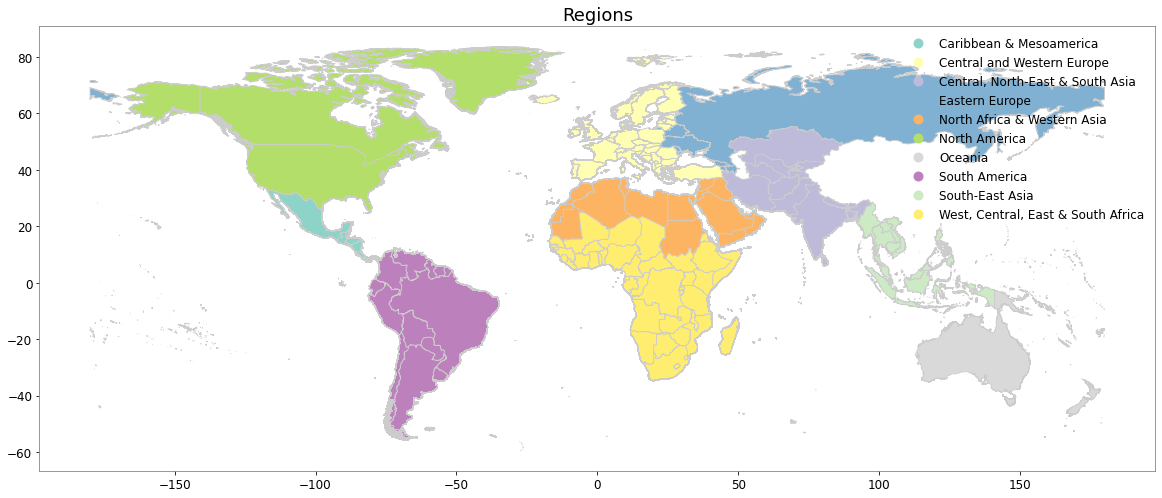

In [24]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame with a colormap based on the 'new_region' column
fig, ax = plt.subplots(figsize=(20, 30))
shp.plot(column='new_region', cmap='Set3', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set plot title
plt.title('Regions')

# Customize the legend
leg = ax.get_legend()
if leg:
    leg.set_frame_on(False)

# Show the plot
plt.show()

In [22]:
mean_species_richness_diff_dict = {'diff_newvalue': {}, 'diff_sumbin': {}}

scenarios = ["rcp26","rcp60"]

# Iterate through unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    for scenario in scenarios:
        # Calculate the absolute difference
        abs_diff_newvalue = mean_over_all_sdms_gcms_fut[scenario] - mean_over_all_sdms_gcms_hist[scenario]
        abs_diff_sumbin = mean_over_all_sdms_gcms_sumbin_fut[scenario] - mean_over_all_sdms_gcms_sumbin_hist[scenario]

        # Extract the bounding box coordinates
        minx, miny, maxx, maxy = region_gdf.geometry.total_bounds

        # Create a boolean mask based on the bounding box
        mask = (
            (abs_diff_newvalue.lon >= minx) & (abs_diff_newvalue.lon <= maxx) &
            (abs_diff_newvalue.lat >= miny) & (abs_diff_newvalue.lat <= maxy)
        )

        # Apply the mask to the DataArrays and calculate the mean species richness
        newvalue_future = mean_over_all_sdms_gcms_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        newvalue_hist = mean_over_all_sdms_gcms_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_future = mean_over_all_sdms_gcms_sumbin_fut[scenario].where(mask).sum(dim=['lat', 'lon']).item()
        sumbin_hist = mean_over_all_sdms_gcms_sumbin_hist[scenario].where(mask).sum(dim=['lat', 'lon']).item()

        # Calculate the relative difference
        rel_diff_newvalue = (newvalue_future - newvalue_hist) / newvalue_hist * 100 if newvalue_hist != 0 else 0
        rel_diff_sumbin = (sumbin_future - sumbin_hist) /  sumbin_hist * 100 if sumbin_hist != 0 else 0

        # Store the relative differences
        mean_species_richness_diff_dict['diff_newvalue'].setdefault(new_region, {})[scenario] = rel_diff_newvalue
        mean_species_richness_diff_dict['diff_sumbin'].setdefault(new_region, {})[scenario] = rel_diff_sumbin

# Print the tables
for variable, region_data_dict in mean_species_richness_diff_dict.items():
    print(f"\n{variable} Relative Difference in Mean Species Richness:")
    result_df = pd.DataFrame(region_data_dict).transpose()
    result_df.to_csv('/storage/homefs/ch21o450/scripts/climate_Hari_etal_inprep/functions/figures/main_figures/Fig_2.csv', index=False)
    print(result_df)



diff_newvalue Relative Difference in Mean Species Richness:
                                       rcp26     rcp60
NaN                                 0.000000  0.000000
Central, North-East & South Asia   -0.995513 -2.850700
West, Central, East & South Africa -0.772359 -3.052900
Central and Western Europe         -0.994369 -2.812708
North Africa & Western Asia        -2.379432 -4.460527
South America                      -6.740422 -8.578988
Eastern Europe                      4.131802  5.284226
Oceania                            -4.012639 -5.747342
Caribbean & Mesoamerica            -3.965562 -6.114813
South-East Asia                    -1.853870 -3.118003
North America                       2.580952  2.923255

diff_sumbin Relative Difference in Mean Species Richness:
                                       rcp26      rcp60
NaN                                 0.000000   0.000000
Central, North-East & South Asia    0.260116  -5.535078
West, Central, East & South Africa  1.030009 -34.495

In [14]:
#newvalue 
import pandas as pd

# Initialize a list to collect detailed results
detailed_results = []

# Iterate through scenarios, SDMs, GCMs, and unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    # Extract bounding box coordinates for the region
    minx, miny, maxx, maxy = region_gdf.geometry.total_bounds
    
    for scenario in scenarios:
        for sdm in sdms:
            for gcm in gcms:


                # Load the relevant DataArray or dataset
                newvalue_hist = mean_newvalue_hist[scenario][sdm][gcm].where(
                    (mean_newvalue_hist[scenario][sdm][gcm].lon >= minx) & (mean_newvalue_hist[scenario][sdm][gcm].lon <= maxx) &
                    (mean_newvalue_hist[scenario][sdm][gcm].lat >= miny) & (mean_newvalue_hist[scenario][sdm][gcm].lat <= maxy),
                    drop=True
                )
                newvalue_fut = mean_newvalue_fut[scenario][sdm][gcm].where(
                    (mean_newvalue_fut[scenario][sdm][gcm].lon >= minx) & (mean_newvalue_fut[scenario][sdm][gcm].lon <= maxx) &
                    (mean_newvalue_fut[scenario][sdm][gcm].lat >= miny) & (mean_newvalue_fut[scenario][sdm][gcm].lat <= maxy),
                    drop=True
                )

                # Assuming summing and then item() is the intended operation to get a scalar
                newvalue_hist_sum = newvalue_hist.sum(dim=['lat', 'lon']).item()
                newvalue_fut_sum = newvalue_fut.sum(dim=['lat', 'lon']).item()

                # Calculate relative difference
                rel_diff = ((newvalue_fut_sum - newvalue_hist_sum) / newvalue_hist_sum * 100) if newvalue_hist_sum != 0 else 0

                # Store the results
                detailed_results.append({
                    'Region': new_region,
                    'Scenario': scenario,
                    'SDM': sdm,
                    'GCM': gcm,
                    'Relative Difference (%)': rel_diff,
                })

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)


# Display the DataFrame (optional)
print(results_df)


            Region Scenario  SDM           GCM  Relative Difference (%)
0              NaN    rcp26  GAM    GFDL-ESM2M                 0.000000
1              NaN    rcp26  GAM  IPSL-CM5A-LR                 0.000000
2              NaN    rcp26  GAM    HadGEM2-ES                 0.000000
3              NaN    rcp26  GAM        MIROC5                 0.000000
4              NaN    rcp26  GBM    GFDL-ESM2M                 0.000000
..             ...      ...  ...           ...                      ...
171  North America    rcp60  GAM        MIROC5                 1.750559
172  North America    rcp60  GBM    GFDL-ESM2M                 4.142317
173  North America    rcp60  GBM  IPSL-CM5A-LR                 3.992923
174  North America    rcp60  GBM    HadGEM2-ES                 5.159465
175  North America    rcp60  GBM        MIROC5                 8.281942

[176 rows x 5 columns]


In [16]:
pd.set_option('display.max_rows', None)  # This will allow all rows to be displayed
pd.set_option('display.max_columns', None)  # This will allow all columns to be displayed

results_df

,Region,Scenario,SDM,GCM,Relative Difference (%)
0,NaN,rcp26,GAM,GFDL-ESM2M,0.000000
1,NaN,rcp26,GAM,IPSL-CM5A-LR,0.000000
2,NaN,rcp26,GAM,HadGEM2-ES,0.000000
3,NaN,rcp26,GAM,MIROC5,0.000000
4,NaN,rcp26,GBM,GFDL-ESM2M,0.000000
5,NaN,rcp26,GBM,IPSL-CM5A-LR,0.000000
6,NaN,rcp26,GBM,HadGEM2-ES,0.000000
7,NaN,rcp26,GBM,MIROC5,0.000000
8,NaN,rcp60,GAM,GFDL-ESM2M,0.000000
9,NaN,rcp60,GAM,IPSL-CM5A-LR,0.000000


In [17]:
import pandas as pd

# Assuming the 'detailed_results' list is already populated as per the previous steps

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)

# Calculate the uncertainty range (min to max of relative differences) for each region and scenario
# Group by region and scenario, then calculate min and max relative differences within each group
uncertainty_ranges = results_df.groupby(['Region', 'Scenario']).agg(
    Min_Relative_Difference=('Relative Difference (%)', 'min'),
    Max_Relative_Difference=('Relative Difference (%)', 'max')
).reset_index()

# Calculate the range as Max - Min
uncertainty_ranges['Uncertainty Range (%)'] = uncertainty_ranges['Max_Relative_Difference'] - uncertainty_ranges['Min_Relative_Difference']

# Display the uncertainty range DataFrame (optional)
print(uncertainty_ranges)

# If you want to merge this information back into the original results for a comprehensive overview
# which includes details per SDM and GCM combination along with the uncertainty range for each region and scenario,
# you can perform a merge operation.

# Merge the uncertainty range information back into the detailed results DataFrame
comprehensive_results_df = pd.merge(results_df, uncertainty_ranges, on=['Region', 'Scenario'], how='left')

#


                                Region Scenario  Min_Relative_Difference  \
0              Caribbean & Mesoamerica    rcp26                -6.542456   
1              Caribbean & Mesoamerica    rcp60               -11.863175   
2           Central and Western Europe    rcp26                -4.217992   
3           Central and Western Europe    rcp60                -5.939844   
4     Central, North-East & South Asia    rcp26                -3.267671   
5     Central, North-East & South Asia    rcp60                -5.843714   
6                       Eastern Europe    rcp26                 2.827450   
7                       Eastern Europe    rcp60                 0.269566   
8          North Africa & Western Asia    rcp26                -4.550349   
9          North Africa & Western Asia    rcp60                -7.742657   
10                       North America    rcp26                 1.348949   
11                       North America    rcp60                -1.729251   
12          

In [21]:

# Transform 'uncertainty_ranges' for easier access
uncertainty_dict = {(row['Region'], row['Scenario']): row['Uncertainty Range (%)'] for index, row in uncertainty_ranges.iterrows()}

# Function to format the output string with uncertainty
def format_with_uncertainty(value, uncertainty):
    return f"{value:.2f}% (+/- {uncertainty:.2f}%)"

# Format and print the results with uncertainties for 'diff_newvalue'
for region, scenarios in mean_species_richness_diff_dict['diff_newvalue'].items():
    for scenario, value in scenarios.items():
        # Retrieve the corresponding uncertainty range
        uncertainty = uncertainty_dict.get((region, scenario), 0)
        formatted_output = format_with_uncertainty(value, uncertainty)
        print(f"{region} - {scenario}: {formatted_output}")

nan - rcp26: 0.00% (+/- 0.00%)
nan - rcp60: 0.00% (+/- 0.00%)
Central, North-East & South Asia - rcp26: -1.00% (+/- 4.36%)
Central, North-East & South Asia - rcp60: -2.85% (+/- 8.95%)
West, Central, East & South Africa - rcp26: -0.77% (+/- 4.55%)
West, Central, East & South Africa - rcp60: -3.05% (+/- 6.55%)
Central and Western Europe - rcp26: -0.99% (+/- 5.27%)
Central and Western Europe - rcp60: -2.81% (+/- 11.06%)
North Africa & Western Asia - rcp26: -2.38% (+/- 4.93%)
North Africa & Western Asia - rcp60: -4.46% (+/- 7.28%)
South America - rcp26: -6.74% (+/- 9.43%)
South America - rcp60: -8.58% (+/- 8.78%)
Eastern Europe - rcp26: 4.13% (+/- 3.93%)
Eastern Europe - rcp60: 5.28% (+/- 13.69%)
Oceania - rcp26: -4.01% (+/- 3.78%)
Oceania - rcp60: -5.75% (+/- 5.04%)
Caribbean & Mesoamerica - rcp26: -3.97% (+/- 5.16%)
Caribbean & Mesoamerica - rcp60: -6.11% (+/- 9.09%)
South-East Asia - rcp26: -1.85% (+/- 2.38%)
South-East Asia - rcp60: -3.12% (+/- 3.24%)
North America - rcp26: 2.58% (+/- 

In [23]:
#sumbin
import pandas as pd

# Initialize a list to collect detailed results
detailed_results = []

# Iterate through scenarios, SDMs, GCMs, and unique new regions
for new_region in shp['new_region'].unique():
    # Select the region-specific geometry from the shapefile
    region_gdf = shp[shp['new_region'] == new_region]

    # Extract bounding box coordinates for the region
    minx, miny, maxx, maxy = region_gdf.geometry.total_bounds
    
    for scenario in scenarios:
        for sdm in sdms:
            for gcm in gcms:


                # Load the relevant DataArray or dataset
                sumbin_hist = mean_sumbin_hist[scenario][sdm][gcm].where(
                    (mean_sumbin_hist[scenario][sdm][gcm].lon >= minx) & (mean_sumbin_hist[scenario][sdm][gcm].lon <= maxx) &
                    (mean_sumbin_hist[scenario][sdm][gcm].lat >= miny) & (mean_sumbin_hist[scenario][sdm][gcm].lat <= maxy),
                    drop=True
                )
                sumbin_fut = mean_sumbin_fut[scenario][sdm][gcm].where(
                    (mean_sumbin_fut[scenario][sdm][gcm].lon >= minx) & (mean_sumbin_fut[scenario][sdm][gcm].lon <= maxx) &
                    (mean_sumbin_fut[scenario][sdm][gcm].lat >= miny) & (mean_sumbin_fut[scenario][sdm][gcm].lat <= maxy),
                    drop=True
                )

                # Assuming summing and then item() is the intended operation to get a scalar
                sumbin_hist_sum = sumbin_hist.sum(dim=['lat', 'lon']).item()
                sumbin_fut_sum = sumbin_fut.sum(dim=['lat', 'lon']).item()

                # Calculate relative difference
                rel_diff = ((sumbin_fut_sum - sumbin_hist_sum) / sumbin_hist_sum * 100) if sumbin_hist_sum != 0 else 0

                # Store the results
                detailed_results.append({
                    'Region': new_region,
                    'Scenario': scenario,
                    'SDM': sdm,
                    'GCM': gcm,
                    'Relative Difference (%)': rel_diff,
                })

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)


# Display the DataFrame (optional)
print(results_df)


                                 Region Scenario  SDM           GCM  \
0                                   NaN    rcp26  GAM    GFDL-ESM2M   
1                                   NaN    rcp26  GAM  IPSL-CM5A-LR   
2                                   NaN    rcp26  GAM    HadGEM2-ES   
3                                   NaN    rcp26  GAM        MIROC5   
4                                   NaN    rcp26  GBM    GFDL-ESM2M   
5                                   NaN    rcp26  GBM  IPSL-CM5A-LR   
6                                   NaN    rcp26  GBM    HadGEM2-ES   
7                                   NaN    rcp26  GBM        MIROC5   
8                                   NaN    rcp60  GAM    GFDL-ESM2M   
9                                   NaN    rcp60  GAM  IPSL-CM5A-LR   
10                                  NaN    rcp60  GAM    HadGEM2-ES   
11                                  NaN    rcp60  GAM        MIROC5   
12                                  NaN    rcp60  GBM    GFDL-ESM2M   
13    

In [24]:
import pandas as pd

# Assuming the 'detailed_results' list is already populated as per the previous steps

# Convert to DataFrame
results_df = pd.DataFrame(detailed_results)

# Calculate the uncertainty range (min to max of relative differences) for each region and scenario
# Group by region and scenario, then calculate min and max relative differences within each group
uncertainty_ranges = results_df.groupby(['Region', 'Scenario']).agg(
    Min_Relative_Difference=('Relative Difference (%)', 'min'),
    Max_Relative_Difference=('Relative Difference (%)', 'max')
).reset_index()

# Calculate the range as Max - Min
uncertainty_ranges['Uncertainty Range (%)'] = uncertainty_ranges['Max_Relative_Difference'] - uncertainty_ranges['Min_Relative_Difference']

# Display the uncertainty range DataFrame (optional)
print(uncertainty_ranges)

# If you want to merge this information back into the original results for a comprehensive overview
# which includes details per SDM and GCM combination along with the uncertainty range for each region and scenario,
# you can perform a merge operation.

# Merge the uncertainty range information back into the detailed results DataFrame
comprehensive_results_df = pd.merge(results_df, uncertainty_ranges, on=['Region', 'Scenario'], how='left')

#


                                Region Scenario  Min_Relative_Difference  \
0              Caribbean & Mesoamerica    rcp26                -5.904964   
1              Caribbean & Mesoamerica    rcp60               -16.638344   
2           Central and Western Europe    rcp26                -0.946715   
3           Central and Western Europe    rcp60                -4.382689   
4     Central, North-East & South Asia    rcp26                -2.179136   
5     Central, North-East & South Asia    rcp60                -8.710117   
6                       Eastern Europe    rcp26                 6.010454   
7                       Eastern Europe    rcp60                 3.423888   
8          North Africa & Western Asia    rcp26                -5.915066   
9          North Africa & Western Asia    rcp60               -24.969929   
10                       North America    rcp26                 5.127856   
11                       North America    rcp60                 0.216148   
12          

In [25]:

# Transform 'uncertainty_ranges' for easier access
uncertainty_dict = {(row['Region'], row['Scenario']): row['Uncertainty Range (%)'] for index, row in uncertainty_ranges.iterrows()}

# Function to format the output string with uncertainty
def format_with_uncertainty(value, uncertainty):
    return f"{value:.2f}% (+/- {uncertainty:.2f}%)"

# Format and print the results with uncertainties for 'diff_newvalue'
for region, scenarios in mean_species_richness_diff_dict['diff_sumbin'].items():
    for scenario, value in scenarios.items():
        # Retrieve the corresponding uncertainty range
        uncertainty = uncertainty_dict.get((region, scenario), 0)
        formatted_output = format_with_uncertainty(value, uncertainty)
        print(f"{region} - {scenario}: {formatted_output}")

nan - rcp26: 0.00% (+/- 0.00%)
nan - rcp60: 0.00% (+/- 0.00%)
Central, North-East & South Asia - rcp26: 0.26% (+/- 5.13%)
Central, North-East & South Asia - rcp60: -5.54% (+/- 8.98%)
West, Central, East & South Africa - rcp26: 1.03% (+/- 4.93%)
West, Central, East & South Africa - rcp60: -34.50% (+/- 9.89%)
Central and Western Europe - rcp26: 1.88% (+/- 4.81%)
Central and Western Europe - rcp60: -1.63% (+/- 10.80%)
North Africa & Western Asia - rcp26: -4.07% (+/- 4.01%)
North Africa & Western Asia - rcp60: -20.70% (+/- 6.83%)
South America - rcp26: -9.06% (+/- 10.22%)
South America - rcp60: -10.88% (+/- 11.98%)
Eastern Europe - rcp26: 7.27% (+/- 3.93%)
Eastern Europe - rcp60: 8.11% (+/- 12.27%)
Oceania - rcp26: -3.87% (+/- 4.55%)
Oceania - rcp60: -16.17% (+/- 9.06%)
Caribbean & Mesoamerica - rcp26: -2.68% (+/- 6.18%)
Caribbean & Mesoamerica - rcp60: -10.33% (+/- 10.05%)
South-East Asia - rcp26: -1.66% (+/- 2.66%)
South-East Asia - rcp60: -4.69% (+/- 3.13%)
North America - rcp26: 6.25% 